In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
import plotly.express as px

# LIME in action
This notebook loosely follows along with the Coursera tutorial [Interpretable Machine Learning Applications: Part 2](https://www.coursera.org/learn/interpretable-machine-learning-applications-part-2/supplement/MhGNK/interpretable-machine-learning-applications-part-2)

## Get the data

In [2]:
df = pd.read_csv("winequality-red.csv")

In [3]:
# check the number of rows, columns
df.shape

(1599, 12)

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Okay, so it seems that the dataset covers some qualities about wine, red wine specifically.  
Time to check for missing data.

In [5]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Great, nothing is missing.  
Lets grab our features.  


In [6]:
# Grab the X feature names
X_feature_names = df.select_dtypes(include=[float]).columns.to_list()
X_feature_names

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol']

In [7]:
# Grab the Y feature names
Y_feature_names = df.select_dtypes(include=[int]).columns.to_list()
Y_feature_names

['quality']

Okay so the X features are all of the qualities of the wine that can be used to predict the Y feature a.k.a **the** quality.  
Lets see how the quality of the wine is distributed. In the tutorial, they simply defined a "good quality" wine as any wine with a quality greater than 7.  
However, they did this without really looking at the distribution of the quality. 

Text(0, 0.5, 'Number of wines')

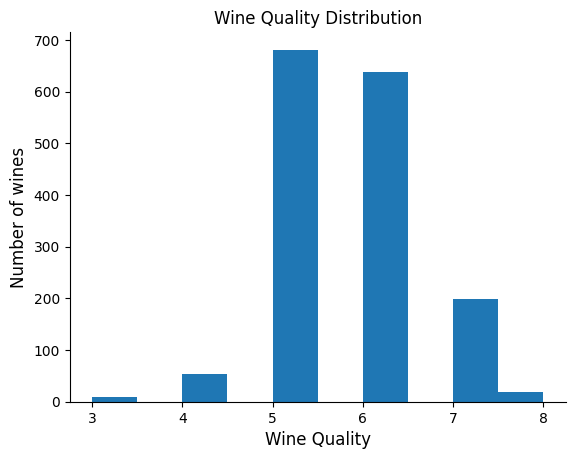

In [8]:
ax = df.hist(column='quality', grid=False)[0][0]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Wine Quality Distribution")
ax.set_xlabel("Wine Quality", size=12)
ax.set_ylabel("Number of wines", size=12)

Well it seems that indeed a good quality wine is one with a `quality` greater than or equal to 7

In [9]:
# Turn this into a binary classification by creating a good quality column
df['good_quality'] = df.quality.apply(lambda x: True if x >= 7 else False)

In [10]:
X = df.drop(['quality', 'good_quality'], axis=1)
y = df.good_quality

In [11]:
# check proportion of good quality wines
df.good_quality.value_counts()

good_quality
False    1382
True      217
Name: count, dtype: int64

In [12]:
# Normalize feature vairbables
from sklearn.preprocessing import StandardScaler
X_features = X
X = StandardScaler().fit_transform(X)

In [13]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=0)
y_test.value_counts()

good_quality
False    430
True      50
Name: count, dtype: int64

## Create some models

### Decision Tree

In [14]:
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

In [15]:
decision_tree = DecisionTreeClassifier(random_state=1)
decision_tree.fit(X_train, y_train)
y_pred_tree = decision_tree.predict(X_test)

In [16]:
tree_report = pd.DataFrame(classification_report(y_test, y_pred_tree, output_dict=True))
tree_report

,False,True,accuracy,macro avg,weighted avg
precision,0.960976,0.485714,0.891667,0.723345,0.911469
recall,0.916279,0.680000,0.891667,0.798140,0.891667
f1-score,0.938095,0.566667,0.891667,0.752381,0.899405
support,430.000000,50.000000,0.891667,480.000000,480.000000


### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(random_state=1)
random_forest.fit(X_train, y_train)
y_pred_forest = random_forest.predict(X_test)

In [18]:
forest_report = pd.DataFrame(classification_report(y_test, y_pred_forest, output_dict=True))
forest_report

,False,True,accuracy,macro avg,weighted avg
precision,0.951724,0.644444,0.922917,0.798084,0.919716
recall,0.962791,0.580000,0.922917,0.771395,0.922917
f1-score,0.957225,0.610526,0.922917,0.783876,0.921111
support,430.000000,50.000000,0.922917,480.000000,480.000000


### AdaBoost

In [19]:
from sklearn.ensemble import AdaBoostClassifier
ada_boost = AdaBoostClassifier(random_state=1, algorithm="SAMME")
ada_boost.fit(X_train, y_train)
y_pred_forest = ada_boost.predict(X_test)

In [20]:
ada_report = pd.DataFrame(classification_report(y_test, y_pred_forest, output_dict=True))
ada_report

,False,True,accuracy,macro avg,weighted avg
precision,0.940618,0.423729,0.877083,0.682173,0.886775
recall,0.920930,0.500000,0.877083,0.710465,0.877083
f1-score,0.930670,0.458716,0.877083,0.694693,0.881508
support,430.000000,50.000000,0.877083,480.000000,480.000000


## LIME Explainer

In [21]:
import lime
import lime.lime_tabular

In [37]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    np.array(X_train),
    mode='regression',
    feature_names = X_feature_names,
    class_names=['goodquality'],
    verbose=True,
)

In [38]:
exp = explainer.explain_instance(X_test[20], random_forest.predict)

Intercept -0.004501343634271279
Prediction_local [0.06490166]
Right: False


The prediction for `X_test[20]` was "bad quality".  
The local prediction was ~0.075 with an intercept of -0.0028.

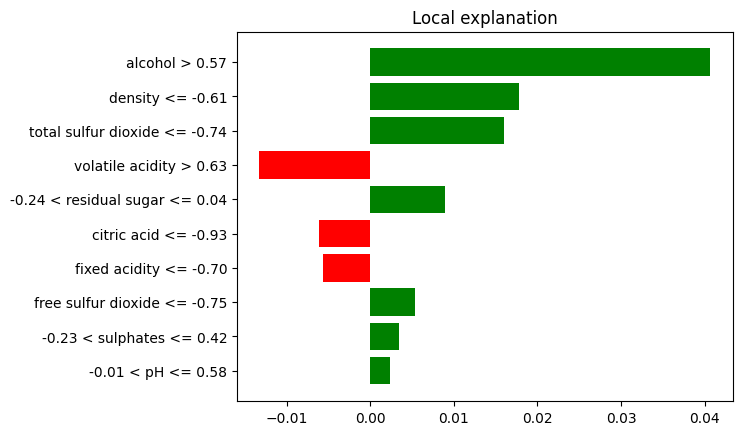

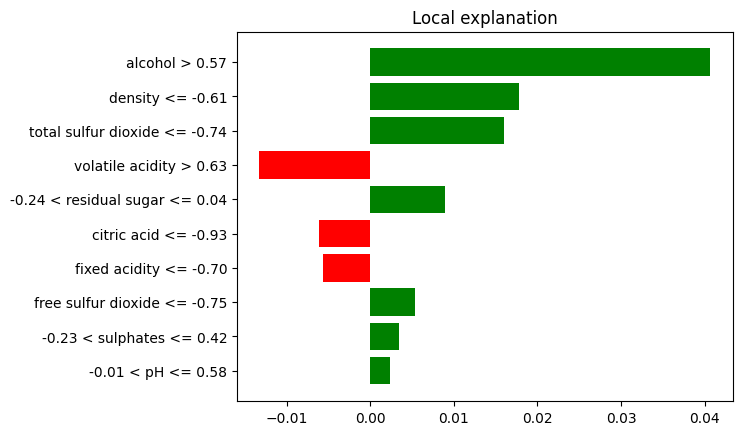

In [46]:
exp.as_pyplot_figure()

This particular red wine has been classified by the random forest model as "bad quality" because it had an alcohol value of greater than 0.57, density less than -0.67, total sulfur dioxide less then -0.74, and so on.  

Now lets check to see if the predictions coincide with what is in the test data set.  

In [50]:
y_test[0:3]

1109    False
1032    False
1002     True
Name: good_quality, dtype: bool

In [51]:
random_forest.predict(X_test[0:3])

array([False, False,  True])

In [52]:
ada_boost.predict(X_test[0:3])

array([False, False,  True])

In [53]:
decision_tree.predict(X_test[0:3])

array([False, False,  True])

Seems that all three models correctly predict the first three wines as they are in the test data.  